# California_Housing_Prices


## Przeanalizowanie zadania 

Mam zamiar wyuczyc model przewidujący mediane cen mieszkań w danym dystrykcie (grupa bloków składa sie od 600 do 3000 osób)
zródłem potrzebnych informacji bedzie spis ludnosci, ponieważ mozemy w nim znaleśc mediane wyliczoną dla tysiecy dystryktów, a także wiele innych danych.


Mamy tu do czynienia z klasycznym zadaniem uczenia nadzorowanego, ponieważ mazna wytrenowac model za pomocą oznakowanych przykładów uczących (każdy przykład ma zdefiniowany od razu oczekiwany wynik, np. mediane cen mieszkan w dystrykcie)
Jest to klasyczne zadanie regresyjne, ponieważ model ma przewidzieć jakąś wartość. Mówiąc dokłądniej, stajemy przed problemem regresji wielorakiej, gdyż do prognozowania wyniku nasz system wykorzysta wiele cech (populacje dystryktu, mediane dochodów)



## Dobór wskaźnika wydajności 

W przypadku zagadnień regresyjnych klasyczną miarą wydajności jest pierwiastek błedu sredniokwadratowego( ang. Root Mean Square Error- RMSE
    Dowiadujemy sie dzieki niemu, w jakim stopniu model myli sie w przewidywaniach- wraz ze wzrostem błędu rośnie waga tego wskaźnika.
    Pomimo ze preferowanym wskaźnikiem wydajności w zadaniach regresyjnych jest pomiar błędu RMSE, w pewnych sytuacjach lepiej sprawdza sie inna funkcja. Załóżmy że w zestawie danych znajduje sie wiele dystryktów odstajacych od reszty. W takim przypadku warto byłoby wyliczyc sredni absolutny błąd (Mean Absolute Error - MAE)
    Obydwie miary (RMSE i MAE) pozwalaja na obliczenie odległosci pomiedzy dwoma wektorami: wektorem prognoz i wektorem watości docelowych

In [1]:
from pathlib import Path 
import pandas as pd
import tarfile #służy do pracy z plikami TAR
import urllib.request # służy do pobiernia danych z internetu
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style = "whitegrid")

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    #zmienna przechwuje scieżke do lokalizacji gdzie plik bedzie zapisany
    if not tarball_path.is_file(): # jesli zmienna nie jest w sciezce
        Path("datasets").mkdir(parents = True, exist_ok = True) # tworzy katalog dataset, jesli istnieje zostanie zignorowany
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()


In [3]:
housing.head() #sprawdza pierwsze 5 wierszy

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info() #sprawdza całkowisa liczbe wierszy, typ danych każdego atrybutu oraz liczbe wartosci niezerowych

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Na zbiór danych składa sie 20 640 przykładów, co oznacza, ze jest on dość mały.
Atrybut total-bedrooms zawiera 20 433 wartości niezerowych, co oznacza ze cecha nie zostałą zdefiniowana dla 207 (wartości) dystryktów
Z wyjątkiem ocean_proximity wszystkie pozostałe atrybuty mają wartości numeryczne 
Typem ocean_proximity jest object, co oznacza ze mozna tu przechowywac dowolny obiekt jezyka python ( wczytałem dane z pliku CSV wiec musi to byc wartosc tekstowa
Po przyjrzeniu sie pierwszym pięciu wierszom zbioru danych okazuje sie, ze wartości w kolumnie ocean_proximity sa powtarzalne, mamy do czynienia z atrybutami kategorialnymi

In [5]:
housing['ocean_proximity'].value_counts() # zliczenie wszystkich wartosci z kolumny 

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

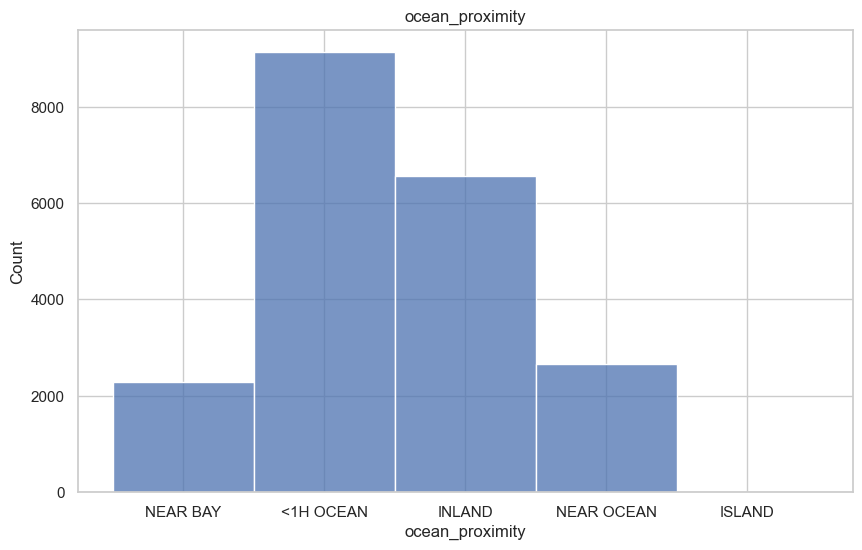

In [6]:
plt. figure(figsize = (10,6))
sns.histplot(housing["ocean_proximity"], bins = 30)
plt.title("ocean_proximity")
plt.show()

<Axes: >

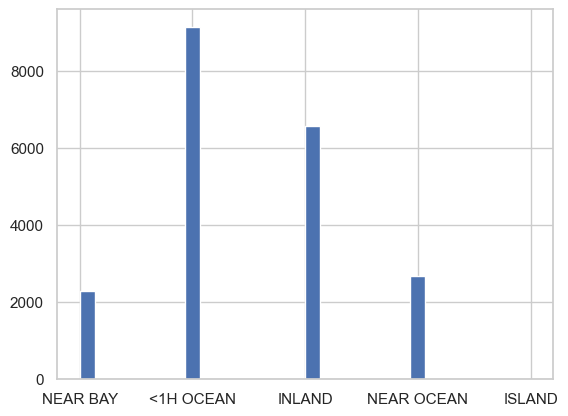

In [7]:
housing["ocean_proximity"].hist( bins = 30)

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### count- liczba 
### mean- średnia
### std- odychylenie standardowe, okresla rozrzut watrosci 
        odchylenie standardowe (sigma) i w ujaciu matematycznym stanowi pierwiastek kawadratowy wariancji, która z kolei definiujemy jako srednia arytmetyczna kwadratów odchylen od wartosci srednich. Gdy wykres danej cechy przyjmuje dzwonowy kształt rozkładu normalnego (rzokład Gaussa) co jest bardzo czesto spotykane, znajduje zastosowanie tzw. reguła 68-95-99,7(mniej wiecej 68% próbek znajduje sie w odległosci 1sigma od wartości oczekiwanej, 95% w odelgłosci 2sigma a 99,7% w odlegósci 3sigma
### 25%, 50%, 75% percentyle
wskazuje wartość, ponizej której znajduje sie okreslony odsetek obserwowanych przykładów, parametry te są czesto nazywane, kolejno 25percentylem (lub pierwszym kwartylem), medianą oraz 75percetylem (trzecim kwartylem)


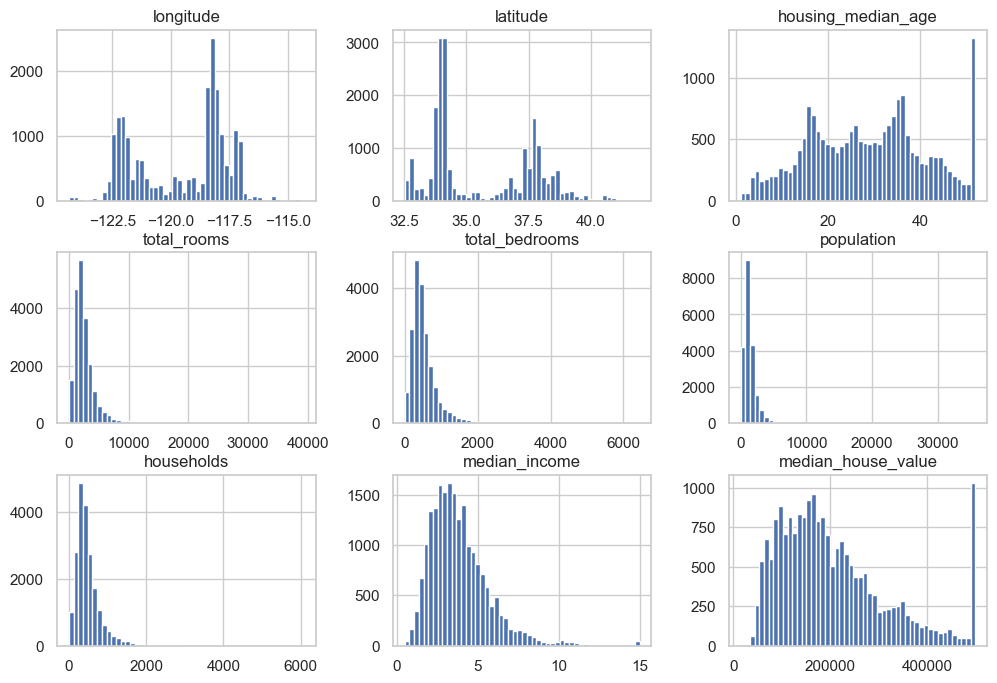

In [9]:
#histogram przedstawia liczbe przykładów (w pionowej osi ) znajdujacych sie w okreslonym przedziale wartosci (os pozioma)
housing.hist(bins = 50, figsize = (12,8))
plt.show()

## wnioski z Histogramów 

- Dane mediany dochodów (median_income) sa przeskalowane (np.5 = 5000 USD ) i ograniczone do maksymalnej wiekosci 15 
- Wartość mediany wieku (housing_median_age) i cen mieszkań (median_house_value) sa ograniczone, 
    cena mieszkań stanowi nasz docelowy atrybut (etykiete), algorytmy uczenia maszynowego mogą uznać ze ceny domów nigdy nie przekroczą gónej ,ograniczonej wartości. Pozostają dwie możliwości:
    - uzyskac prawidłowe etykiety dla dystryktów mających obciete górne wartości cen
    - usunąc te dystrykty z zestawu uczącego i testowego poniewaz system nie powinien byc karany, jeżeli będzie przewidywał wartości przekraczające 500 000 dolarów
- każdy z tych artybutów jest ukazany w odmiennych skalach
- wiele histogramów cechuje sie prawoskośnościa: rozciagają sie one znacznie bardziej po prawej stronie mediany niz po lewej

## Tworzenie zbioru testowego 

In [10]:
 def shuffle_and_split_data(data, test_ratio):
        shuffled_indices = np.random.permutation(len(data)) #generuje losową permutacje indeksów wszystkich rekordów w zbiorze
        test_set_size = int(len(data)* test_ratio) # mnoży długosc zbioru danych przez liczbe określająca proporcje danych 
        test_indices = shuffled_indices[:test_set_size] #wycina elementy od poczatku listy az do pozycji test_set_size (ale nie włacznie z nią)
        train_indices = shuffled_indices[test_set_size:]# wycina elementy od pozycji test_set_size az do konca listy
        return data.iloc[train_indices],data.iloc[test_indices] # na podstawie indeksów wybiera wiersze ze zbioru danych

In [11]:
train_set, test_set = shuffle_and_split_data(housing,0.2)

In [12]:
len(train_set)
len(test_set)

4128

To rozwiazanie nie jest idealne: przy nastepnym uruchomieniu programu zostanie wygenrowany zupełnei inny zbiór testowy. 
Po pewnym czasie przejde przez cały zbiór danych uczacych

In [13]:
from zlib import crc32
def is_id_is_test_set(identifier,test_ratio):
    return crc32(np.int64(identifier))< test_ratio * 2 ** 32
def split_data_with_id_hash(data,test_ratio,id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_is_test_set(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2,"index")

Moduł Scikit-Learn zawiera kilka róznych funkcji rozdzielających zbiory danych na wiele podzbiorów.
Najprostszą z nich jest train_test_split()
- Mamy tu do czynienia z parametrem random_state pozwalajacym wybraz zarodek liczb losowych
- Mozemy przekazywac wiele zbiorów danych majacych taka sama liczbe wierszy- beda one rozdzielone pomiedzy takie same indeksy 

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state = 42)

Metoda ta stosuje całkowicie losowe probkowanie, takie rozwiazanie nie spisuje sie dobrze w przypadku duzego zbioru danych.
"gdy pracownicy urzedu statystycznego zamierzaja przeprowadzic ankiete na tysiacu osób, musza zostac tak dobrane, 
aby stanowiły reprezentatywny przykłąd całej populacji w kontekscie zadawanych pytan"

Ważnym atrybutem pomagającym w prognozowaniu mediany cen meszkań jest mediana dochodów. Zbiór testowy powinien wiernie reprezentowac rózne kategorie dochodó dla całego zbioru danych. Mediana dochodów stanowi atrybut ciągłych wartosci numerycznych, dlatego najpierw należy stworyzc atrybuty kategoriii dochodów.
Z histogramu mediany dochodów, wiekszosc miesci sie w przedziale od 1,5 do 6 (15000 - 60000), jednak niektóre znacznie przekraczają 6. Ważne jest aby każda warstwa zestawu danych zawierałą wystarczającą liczbę przykładów, gdyż w przeciwnym wypadku oszacowanie znaczenia danej warstwy może byc nieadekwatne do rzeczywistości. Oznacza to ze nie mozemy tworzyc zbyt wielu warstw i każda z nich powinna byc wystarczająco duża.
Poniższy kdo wykorzystuje funkcje pd.cut() do utworzenia atrybutu kategorii dochodów składającego sie z pieciu kategorii 
(oznaczonych cyframi od 1 do 5) zakres pierwszej kategorii wynosi od 0 do 1,5 ( tzn. poniżej 15 000 dolarów), itd.

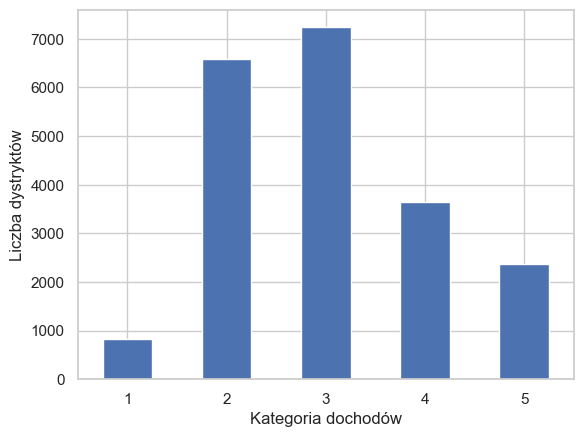

In [16]:
housing['income_cat'] = pd.cut(housing['median_income'],bins = [0.,1.5,3.0,4.5,6., np.inf],labels = [1,2,3,4,5])
housing['income_cat'].value_counts().sort_index().plot.bar(rot =0,grid = True)
plt.xlabel('Kategoria dochodów')
plt.ylabel('Liczba dystryktów')
plt.show()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state= 42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']): #wykonuje stratyfikowany podział na danych housing i zmiennej housing['income_cat']
    #zmienna housing['income_cut'] to zmienna kategorialna która kontroluje aby proporcje tych kategorii były takie same w zestawach treningowym i testowym
    strat_train_set_n = housing.iloc[train_index] # lista indeksów zawier
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n,strat_test_set_n])

In [18]:
strat_train_set, strat_test_set = strat_splits[0]

łąwiej dokonac jednokrotnego podziału za pomoca funkcji train_test_split() z argumentem stratify

In [19]:
strat_train_set,strat_test_set = train_test_split(housing,test_size= 0.2, stratify= housing['income_cat'], random_state = 42)

In [20]:
strat_test_set["income_cat"].value_counts()/ len(strat_test_set)# sprawdzam proporcje kategorii dochodów w zestawie testowym

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [21]:
for set_ in (strat_train_set,strat_test_set): # usuniecie kolumny income_cat
    set_.drop('income_cat',axis = 1, inplace = True)

podczas eksperymentowania z róznymi przekształceniami pełnego zbioru uczacego, 
warto stworzyc kpie orginału aby wrócic do niego po zakonczeniu pracy

In [22]:
housing = strat_train_set.copy()

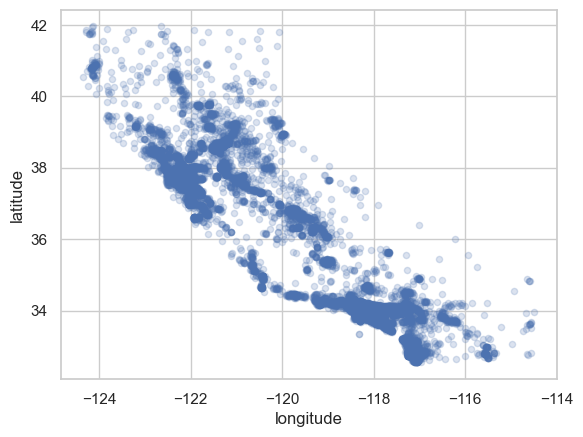

In [23]:
# wizualizacja danych geograficznych
housing.plot(kind= 'scatter',x= 'longitude', y= 'latitude', grid= True, alpha = 0.2)
plt.show()
#kind - okresla rodzaj wykresu który chcemy stworzyc 
#       scatter- wykres rozrzutu
#x,y- reprezentowac współrzedne na X, y
#grid- ustawia czy na wykresie ma byc wyswietlana siatka 
#alpha- kontoroluje przezroczystosc punktów (0,2 = 20%nieprzezroczystosci)

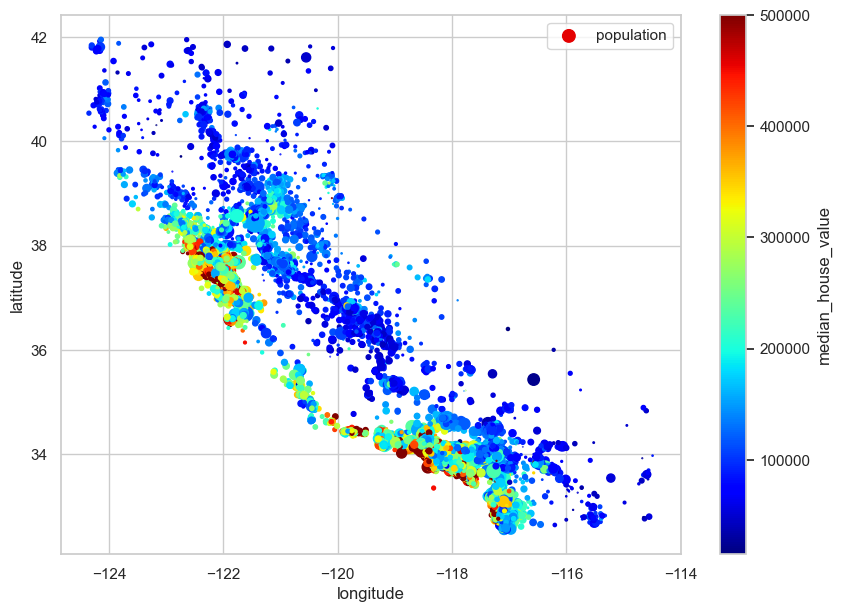

In [24]:
housing.plot(kind="scatter", x= "longitude", y= "latitude", grid = True, s= housing["population"]/100,
             label = "population",c = "median_house_value",cmap = 'jet', colorbar = True, legend = True,
             sharex = False, figsize = (10,7))
plt.show()
# s- wielkość promienia symoblizuje populacje dystryktu, wartosc populacji jest dzielona przez 100, aby uzyskac odp. rozmiar 
# c- okresla kolor ceny domów w danej lokalizacji 
# cmap- okresla mape kolorów o nazie jet której zakes miesci sie od niebieskiego do czerwonego przekazywana do zmiennej c
# colorbar- pasek kolorów obok wykresu 
# legend- legenda na wykresie 


### wnioski na podstawie wykresów

- ceny mieszkan sa w dzuje mierze uzależnione od połozenia geograficznego (odlegosci od oceanu) i zaludnienia
- 

In [25]:
#współczynnik koleracji liniowej ( współczynnik korelacji Pearsona)
housing_num = housing.select_dtypes(include=[np.number])  #tworzymy kopie zbioru danych wylacznie za pomocą atrybutów numerycznych

corr_matrix = housing_num.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

### wnioski 
Wartości współczynnika korelacji mieszczą sie w zakresie pomiedyz -1 a 1.
wartość zbliżone do 1 wskazują silną korelacje dodatnią:
    - mediana cen mieszkan zazwyczaj rośnie wraz ze wzrostem dediany dochodów
    - wartosci zbliżone do -1 mówia ze istnieje korelacja ujemna 
    ( niewielka korelacja ujemna pomiezdzy szerokoscia geograficzna a mediana cen mieszkan)

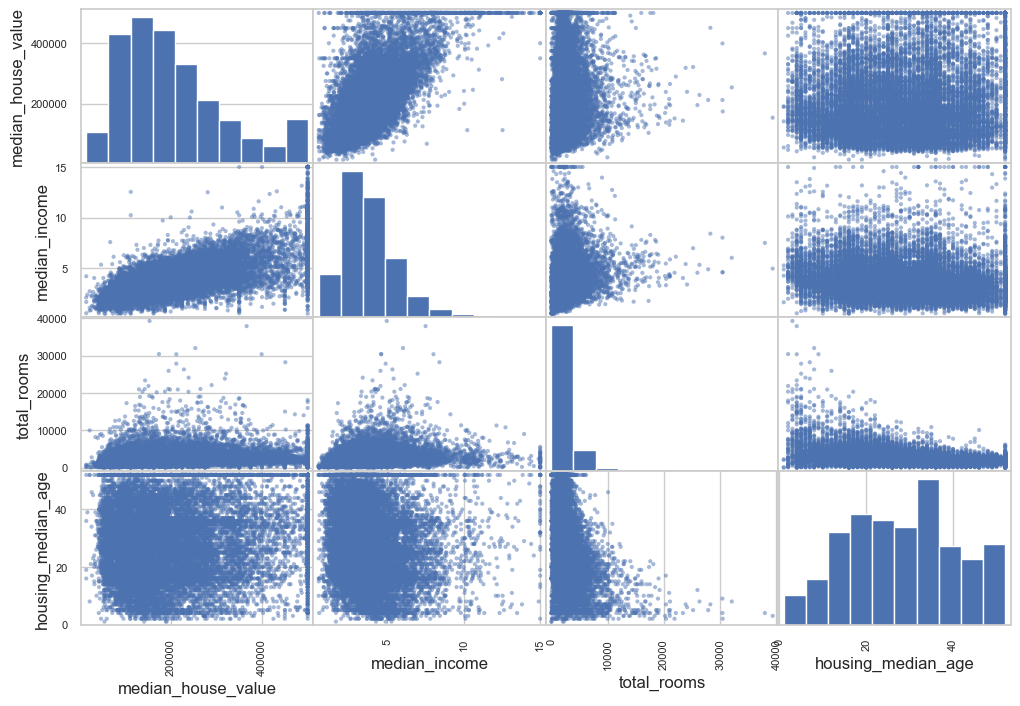

In [26]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes],figsize= (12,8))
plt.show()

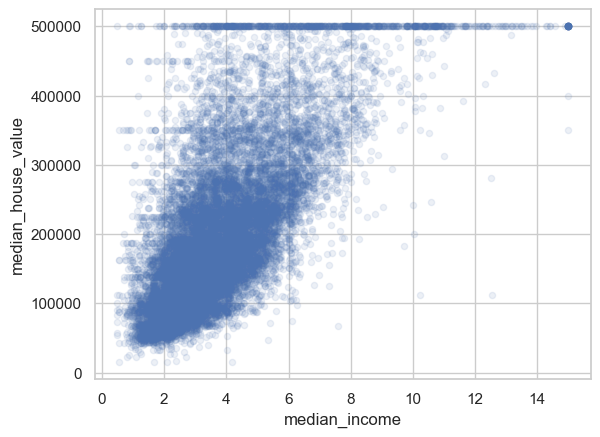

In [27]:
housing.plot(kind= "scatter", x= "median_income", y= "median_house_value", alpha=0.1, grid= True)
plt.show()

### wnioski na podstawie wykresu korelacji

- korelacja miedzy tymi atrybutami jest silna 
- widac ogólny trend wzrostu mediany wartości domów wraz ze wzrostem mediany dochodów oznacza to ze wyższe dochody są związane z wyższymi cenami domów
- ograniczenie ceny domów (górny limit) 
- wiekszość danych jest skupiana w dolnej cześci wykresu (nicska mediana dochodów oraz mediana cen domów
- wystepuje prosta pozioma w punkcie 450 000, 300 000, 280 000

In [28]:
housing['pokoje na rodzine'] = housing['total_rooms']/housing['households']
housing['współczynnik_sypialni'] = housing['total_bedrooms']/housing['total_rooms']
housing['liczba_osób_na _dom'] = housing['population']/housing['households']


In [29]:
corr_matrix = housing_num.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

### wnioski 
- Nowy atrybut wspólczynnik_sypialni jest znacznie bardziej skorelowany z mediana cen mieszkan niz total_rooms lub total_bedrooms. Wynika z tego ze mieszkania o mniejsyzm wspólczynniku liczby sypialni do liczby pomieszczeń okazują sie droższe.
- atrybut pokoje_na_rodzine dastarcza na wiecej informacji niz całkowita total_rooms dosc oczywiste jest ze wraz z powierzchnia domu rosnie jego cena

In [30]:
housing = strat_train_set.drop("median_house_value", axis= 1)#usuniecie kolumny( axixs=1)
housing_labels = strat_train_set['median_house_value'].copy()

## oczyszczenie danych 
wiekszosc algorytóm ucznia maszynowego nie moze działac jesli brakuje jakichs cech, istnieja trzy mozliwosci:
- pozbyc sie brakujachy danych
- pozbyc sie całego atrybutu 
- Imputacja uzupełnic brakujące daneokresloną wartościa(zero,srednia, mediana, )  

Najbardziej racjonalnym i najmniej destrykcyjnym rozwiazaniem bedzie zastapieniem mediana pustych danych.
Skorzystam z przydatnej klasy SimleImputer.
Duza zaleta jest mozliwosc przechowywania wartości mediany kazdej cechy: dzieki temu mozliwe bedzie wstawianie brakujacych wartosci nie tylko w zbiorze uczącym ale takze w zbiorze walidacyjnym, testowym oraz we wszelkich nowych danych wprowadzonych do modelu..


In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'median') #tworzymy instancje klasy SimpleImputer w którym,
#bedziemy zastępowac brakujące watrosci kazdego atrybutu medianą tego atrybutu


In [32]:
# za pomocą atrybutów numerycznych mozemy dostosowac wystąpienie klasy Imputer do danych uczacych za pomocą medoty fit()
imputer.fit(housing_num)
# polega na nauczeniu obietku imputer median poszczegółnych kolumn numerycznych w zbiorze danych housing_num 

SimpleImputer(strategy='median')

In [33]:
imputer.statistics_

array([-1.1851e+02,  3.4260e+01,  2.9000e+01,  2.1250e+03,  4.3400e+02,
        1.1670e+03,  4.0800e+02,  3.5385e+00,  1.7920e+05])

In [34]:
housing_num.median().values

array([-1.1851e+02,  3.4260e+01,  2.9000e+01,  2.1250e+03,  4.3400e+02,
        1.1670e+03,  4.0800e+02,  3.5385e+00,  1.7920e+05])

Klasa imputer po prostu obliczyła mediane atrybutu i zachowała wyniki w zmiennej statistics_.
Jedynie w atrybucie total_bedrooms brakuje niektórych wartości, lecz mozeliwe jest ze po uruchomieniu ostatecznej wersji systemu beda nowe brakujące wartosci, daltego najbezpiecznijeszym rozwiazaniem jest zastosowanie klasy imputer wobec wszystkich atrybutó numerycznych

In [35]:
#wykorzystanie wytrenowanej klasy imputer do przekształcenia zbioru uczącego zastepując brakujące wartości obliczonymi medianami 
X = imputer.transform(housing_num)
#transform()to metoda która dokonuje zamiany brakujących wartości na wczesniej obliczone mediany w każdej kolumnie
#X

Mozna również zastąpic brakujące wartosci wartościa średnia( strategy= "mean") lub najczesciej wystepująca wartoscia
(strategy= 'most_frequent') albo wartościa stałą (strategy= "constant", fill_value= ...

In [36]:
#Transformatory Sccikit-Learn dają na wyjsciu tablice Numpy 
#X nie zawiera nazw kolumn ani indeku
#umieszczamy obiekt X w obiekcie dataframe i odzyskujemy nazwy kolumn i indeksów
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

## Atrybuty tekstowe

In [37]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


### Wnioski

- Istnieje tu ograniczona liczba wartosci, z których kazdan reprezentuje atrybut kategorialny 

Algorytmy uczenia maszynowego lepiej sobie radza z liczbami, przekształcmy wiec te kategorie z tekstu na wartosci numeryczne.
Mozemy w tym celu uzyc klasy OrdinalEncoder

    OrdinalEncoder to klasa która jest uzywana do przekształcania (kodowania) dnaych kategorycznych na wartości liczbowe.
    Kazda unikalna kategoria w danych zostaje przypisana do unikalnej liczby całkowitej.

In [38]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [39]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [40]:
#Mozemy uzyskac liste kategorii za pomoca wystąpienia zmeinnej categories_
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Wnioski
Istnieje problem z tym rozwiazaniem poniewaz algorytmy uczenia maszynowego będa uznawały ze dwie zbliżone wartości będa bardzije do siebie podobne niż do dlaszych wartości. W pewnych przypadkach nie stanowi to problemu ( np. przy uporzadkowanych kategoriach takich jak "zły", "przecietny", "dobry" i znakomity), ale nie dotyczy to kolumny ocean_proximity
Powszechnie stosowanym rozwiazaniem jest jednego binarnego atrybutu dal kazdje kategorii 
    jedne atrybut ma wart. 1, gdy gdy kategorią jest NEAR BAY w przeciwnym wypadku dostaje 0
    inny atrybut uzyskuje wartość 1 dla kategorii INLAND i 0 dla pozostałych kategorii 
Jest to tzw. kodowanie gorąco jedynkowe, poniewaz tylko jeden atrybut bedzie gorący (wart. 1), podczas gdy pozostałe 
bedą zimne (wart. 0 )

### Wnioski
Istnieje problem z tym rozwiazaniem poniewaz algorytmy uczenia maszynowego będa uznawały ze dwie zbliżone wartości będa bardzije do siebie podobne niż do dlaszych wartości. W pewnych przypadkach nie stanowi to problemu ( np. przy uporzadkowanych kategoriach takich jak "zły", "przecietny", "dobry" i znakomity), ale nie dotyczy to kolumny ocean_proximity
Powszechnie stosowanym rozwiazaniem jest jednego binarnego atrybutu dal kazdje kategorii 
    jedne atrybut ma wart. 1, gdy gdy kategorią jest NEAR BAY w przeciwnym wypadku dostaje 0
    inny atrybut uzyskuje wartość 1 dla kategorii INLAND i 0 dla pozostałych kategorii 
Jest to tzw. kodowanie gorąco jedynkowe, poniewaz tylko jeden atrybut bedzie gorący (wart. 1), podczas gdy pozostałe 
bedą zimne (wart. 0 )


In [41]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder() #tworzymy obiekt który jest instancja klasy OneHotEncoder
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)# analizuje dane z housing_cat (identyfikuje unikalne kat.) i przekształca na macierz binarna 
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Domyslnym wynikiem funkcji OneHotEncoder jest macierz rzadka (sparse matrix) bibioteki SciPy.
- Macierz rzadka jest bardzo skutecznym odwzorowaniem macierzy zawierających głównie zera. Przechowywane sa w niej jedynie wartości neizerowe oraz informacje i ich połozeniu. Gdy atrybut kategorialny zawiera setki bądz tysiące kategorii, zakodowanie go w sposób "goroącojedynkowy " skutkuje powstaniem macierzy wypełnionej zerami, w któej wystepuje tylko jedna jedynka na kazdy wiersz. Macierz rzadka pozwala zaoszczędzic mnóstwo pamieci i przyspieszyc obliczenia. Przeważnie można korzystac z macierzy rzadkiej jak ze zwykłej macierzy dwuwymiarowej, a jesli chcesz ja przekształcić w tablice NumPy (gęstą) wystarczy wywołąc metode toarray().
    Ewantualnie mozesz wyznaczyc sparse= False podczas tworzenia klasy OneHotEncoder, metoda fit_transform() bezpośrednio zwróci zwykłą (gestą) tablice Numpy
    
        cat_encoder = OneHotEncoder(sparse= False)


In [42]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Jesli pojawi sie nieznana kategoria, klasa OneHotEncoder wykryje niezgodna kategorie i spowoduje wyswietlenie komunikatu o wyjątku. Jeśli chcemy tego uniknąc mozemy wyznaczyc wartość 'ignore' hipermarametru handle_unknown co sprawi ze naznane kategorie beda oznaczane jako 0 


In [43]:
cat_encoder.handle_unknown = 'ignore'
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

### Skalowanie i przekształcanie cech 
Jednym z najważniejszych przekształcen dokonywanych na danych jest skalowanie cech. Wiekszość algorytmów uczenia maszynowego słabo sobie radzi z atrybutami numerycznymi znajdującymi sie w róznych zakresach skali.
W zbiorze danych całkowita liczba pomieszczeń mieści sie w zakresie od 6 do 39 320, z kolei wartości mediany dochodów to zakres zaledwie od 0 do 15. Bez skalowania wiekszość modeli bedzie ignorowała mediany dochodów i koncentrowała sie bardziej na liczbie pomieszczeń
Istnieja dwa popularne rodzaje skalowania wszystkich atrybutów do jednego poziomu :
- skalowanie min. - max.(normalizacja) dla kazdego atrybutu wartości sa tak przesuwane i skalowane ze meiszcza sie w zakresie pomiedzy 0 i 1. Osiaga sie to odejmując od danej wartosci wartość minimalna i dzilac otzymany wynik przez różnice miedzy wartościa maksymalną i minimalną 

- standaryzacja - najpierw od danej wartosci jest odejmowana średnia( czyli srednia w standaryzowanych próbkachzawsze wynosi 0), a nastepnie wynik jest dzielony przez odchylenie standardowe( dzieki czemu odchylenie standardowe wartości standaryzowanych jest równe 1) W przeciwienstwie do skalowania min-max nie ogranicza skalowanych wartości do okreslonego zakresu. Z drugiej strony standaryzacja jest znacznie mnie wazliwa na elementy odstające.

In [44]:
# Normalizacja
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_sacled = min_max_scaler.fit_transform(housing_num)
#housing_num_min_max_sacled

In [45]:
# Standaryzacja
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)


In [46]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[['housing_median_age']],[[35]],gamma=0.1)
#age_simil_35

In [47]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler() #tworzymy obiekt który bedzie uzyty do skalowania(standaryzacji) zmiennej docelowej
scaled_labels = target_scaler.fit_transform (housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[['median_income']].iloc[:5]
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [48]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression


model = TransformedTargetRegressor(LinearRegression() , transformer = StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions= model.predict(some_new_data)

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Podobieństwo {i} skupienia" for i in range(self.n_clusters)]

## Wprowadzenie Klasy Pipeline

Skorzystanie z klasy Pipeline pomoże wyznaczyc odpowiednia sekwencje transformacji.

In [50]:
# niewielki potok stosowany wobec atrybutó numerycznych który najpierw imputuje a nastepnie skaluje cechy wejsciowe
from sklearn.pipeline import Pipeline 

num_pipeline = Pipeline([
    ('impute',SimpleImputer(strategy= 'median')),
    ('standarize', StandardScaler())
])

In [51]:
import sklearn 
sklearn.set_config(display= 'diagram')
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standarize', StandardScaler())])

In [52]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())

Do tej pory zajmowalem sie oddzielnie kolumnami kategorialnymi i numerycznymi. Było wygodniej gdybym dysponował pojedynczym transformatorem pretwarzajacnym wszystkie kolumny i dobierajacym odpowiednie przekształcenia do poszczególnych typów kolumn

In [53]:
from sklearn.compose import ColumnTransformer 
#definiujemy liste nazw kolmn numerycznych
num_attribis = ['longitude', 'latitude', 'housing_median_age','total_rooms', 'total_bedrooms','population','households','median_income']

#definiujemy liste z nazwa klumny kategorialnej 
cat_attribs = ['ocean_proximity']

#
num_pipeline = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())

#
cat_pipeline = make_pipeline(SimpleImputer(strategy= 'most_frequent'),OneHotEncoder(handle_unknown='ignore'))

#konsturktor, ktry zawiera liste tripletow (3krotek , nazwa, transformator, lista nazw kolumn)
preprocessing = ColumnTransformer([('num', num_pipeline, num_attribis),
                                   ('cat',cat_pipeline, cat_attribs)
                                  ])

In [58]:
from sklearn.compose import make_colun_selector, make_column_transformer
processing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include= np.number)),
    (cat_pipeline, make_coulmn_selector(dtype_include= object))
)
housing_prepared = processing.fit_transform(housing)

ImportError: cannot import name 'make_colun_selector' from 'sklearn.compose' (D:\Programy\Anaconda3\Lib\site-packages\sklearn\compose\__init__.py)

Stworzenie pojedynczego potoku który bedzie realizował wszystkie omówione do tej pory przekształcenia.
- Brakujące wartosci w cechach numerycznych beda wstawiane poprzez zastąpienie ich medianą, gdyż wiekszośc algorytmów uczenia maszynowego nie brakujacych danych. W cechach kategorialnych brakujace wartosci beda zastepowane najczesciej wystepujaca kategoria
- Cecha kategorialna bedzie kodowana "gorącojedynkowo" gdyz wiekszosc algorytmów ML akceptuje na wejsciu wyłacznie dane numeryczne
- Zostanie oblizonych i dołaczonych kilka cech współczynnikowych: wspołczynnik_sypialni (bedrooms_ratio), pokoje_na_rodzine(room_per_house), liczba_osób_na_dom(people_per_house)
- Zostanie dodanych także kilka cech podobienstwa skupien. Prawdopodobnie okażą sie one bardziej przydatne od współrzednych geograficznych
- Cechy długoogonowe zostaną zastąpione ich logarytmami, gdyż wiekszość modeli preferuje cechy o rozkłądach mniej wiecej jednostajnych lub Gaussa
- Wszystkie cechy numeryczne bedą standaryzowane, gdyż wiekszosc algorytmów ML preferuje cechy o mniej wiecej takiej samej skali

In [59]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import numpy as np


#funkcja przyjmuje macierz X jako argument
#funkcja zwraca wartosc ilorazu pierwszej kolumny przez druga kolumne (np. liczba sypialni do liczby pokoi)
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]
#funkcja nadaje nazwy wynikowym cechom po transformacji
#
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # nazwy cech

#funkcja tworzy pipeline
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"), 
        FunctionTransformer(column_ratio, feature_names_out=ratio_name), 
        StandardScaler()) #normalizuje dane, skalujac je tak aby mialy srednia 0 i odchylenie standardowe 1 
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),# wypełnia brakujace wartosci mediana kolumn 
    FunctionTransformer(np.log, feature_names_out="one-to-one"), #stosuje tranformacje logarytmiczna na wybranych kolumnach (p.log logarytm naturalny),
     #feature_names_out = oent-to-one pznacza ze nazwy kolumn po transforamcji pozostana takie same
    StandardScaler()) #skaluje dane

#tworzy wektro podobienstwa da kazdego wiersza na podstawie odleglosci do 10 klastrów( grup)
#gamma kontroluje wpływ odleglosci 
#random_state zapewnia powtarzalnosc wyników
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

preprocessing = ColumnTransformer([
        ("współczynnik_sypialni", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("pokoje_na_rodzinę", ratio_pipeline(), ["total_rooms", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population","households", "median_income"]),  
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),],
    remainder= default_num_pipeline),


In [60]:
#funkcja przyjmuje macierz X jako argument
#funkcja zwraca wartosc ilorazu pierwszej kolumny przez druga kolumne (np. liczba sypialni do liczby pokoi)
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#funkcja nadaje nazwy wynikowym cechom po transformacji
#
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # nazwy cech

#funkcja tworzy pipeline
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),#wypełnia brakujące wartosci mediana kolumnyc
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),#uzywa funkcji column_ratio do obliczenia współczynnika dwuch kolumn,
        #w wyniku dodaje kolumne o nazwi ratio
        StandardScaler())#normalizuje dane, skalujac je tak aby mialy srednia 0 i odchylenie standardowe 1 

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),# wypełnia brakujace wartosci mediana kolumn 
    FunctionTransformer(np.log, feature_names_out="one-to-one"),#stosuje tranformacje logarytmiczna na wybranych kolumnach (p.log logarytm naturalny),
     #feature_names_out = oent-to-one pznacza ze nazwy kolumn po transforamcji pozostana takie same
    StandardScaler())#skaluje dane
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("współczynnik_sypialni", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),# oblicz wspólczynnik sypialni do liczby pokoi
        ("pokoje_na_rodzinę", ratio_pipeline(), ["total_rooms", "households"]),#oblicz wspólczynnik liczby pokoi na gospodarstwo domowe
        ("liczba_osób_na_dom", ratio_pipeline(), ["population", "households"]),# kolumny numeryczne sa poddawane transformacji logarytmicznej
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),#tworzy nowe kolumny na podstawie odlegosci od centroidów klastrów
        ("geo", cluster_simil, ["latitude", "longitude"]),# przekształca kolumny tekstowe (kategorialne na wektory wypu one-hot)
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),# dla pozostałych kolumn które nie sa wyraznie wymienione, zostanie uzyty domyslny pipeline (wypenienie mediana i sklowanie)
    ],
    remainder=default_num_pipeline)  # pozostaje jedna kolumna: housing_median_age

In [61]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Programy\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


(16512, 24)

## Trenowanie modelu


In [62]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing,LinearRegression())
lin_reg.fit(housing,housing_labels)

D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('współczynnik_sypialni',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function rati...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D7A6BB2250>)])),
                ('linearregression', LinearRegression())])

In [63]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2) # -2 = zaokrąglone do najbliższej setki

array([242800., 375900., 127500.,  99400., 324600.])

In [64]:
housing_labels.iloc[:5]

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64

In [65]:
#oblicza współczynniki błędu
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-47.0%, -22.3%, 25.4%, 3.4%, -10.3%


Jak widac model działa, ale nie w kazdym przypadku
- w pierwszym przypadku prognoza jest mylna o ponad 200 000 dolarów
- natomiast pozostałe sa nieco lepsze  dwie odstaja o ok 25 %
- a pozostałe dwie o niecałe 10%


### Model regresji liniowej

In [66]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared= False)
lin_rmse

68647.95686706711

Wynik nie jest powalający: wartosc atrybutu median_housing_values dla wiekszosci dystryktów mieszcza sie w zakresie pomiedzy 120 000 a 265 000 dolarów dlatego standardowy błąd predykcji rzedu 68 647 dolaró nie jest satysflakcjonowujacy. Jest to klasyczny przkład niedotrenowania modelu wobec danych uczacych. Taka sytuacja ozacza ze cechy nie dostarczaja odpowiedniej ilosci informacji pozwalajacych na uzyskanie dobrych prognoz albo ze model nie jest wystarczajaco dobry

Podstawowymi sposobami radzenia sobie z problemem niedotrenowania sa:
- wybór potezniejszego algorytmu 
- wprowadznie lepszych cech
- zmniejszenie ograniczen modelu 

### Model drzewa decyzyjnego

In [67]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state= 42))
tree_reg.fit(housing,housing_labels)

D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('współczynnik_sypialni',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function rati...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D7A6BB2250>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [68]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

Model został przetrenowany

##### Kroswalidacja funkcja f krotnego sprawdzianu krzyżowego.
Zbiór uczacy zostaje losowo rozdzielony na 10 nienakładających sie podzbiorów (folds), nastepnie przeprowadzane jest dziesieciokrotne trenowanie i ocenianie modelu drzewa decyzyjnego( za kazdym razem zostaje wybrany inny podzbiór do oceny wydajnosci modelu a dziewiec pozostałych do uczenia ) W konsekwencji dostajemy tablice 10 wyników ewaluacji.
- Funkcja sprawdzianu krzyżowego oczekuje funkcji użytecznosci (im, wieksza wartosc, tym lepiej), a nie funkcji kosztu (im mniejsza wartosc tym lepiej), dlatego funkcja zliczajaca wynik stanowi w rzeczywistosci przeciwieństwo błedu RMSE

In [69]:
from sklearn.model_selection import cross_val_score #importowanie funkicji walidacji krzyżowej 
tree_rmses = -cross_val_score(tree_reg,housing,housing_labels,scoring = 'neg_root_mean_squared_error',cv =10) 

# scoring='neg_root_mean_squared_error' metryka według której bedzie oceniany model ujemny pierwiastek błędu sredniokwadratowego
# przed uzyskaniem finalnego wyniku, musimy zmienic znaki na dodatnie stąd -cross_val_score(...) zmiania wartosci na pozytywne dajac rzeczywiste wartosci RMSE
tree_rmses

D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

array([66343.67404108, 63925.25310602, 66874.84912025, 66716.81062178,
       65930.10085465, 70664.63583294, 66933.74083972, 68454.11092405,
       69693.52916464, 65996.47822622])

In [70]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

Wyglada nato ze model drzewa decyzyjnego sprawuje sie niemal tak kiepsko jak model regresji liniowej 

### Model lasów losowych
Mechanizm działania modeli losowego lasu  polega na uczeniu wielu drzew decyzyjnych za pomoca róznych podzbiorów cech, po czym nastepuje usrenienie otzymanych prognoz 

In [71]:
from sklearn.ensemble import RandomForestRegressor
    
forest_reg = make_pipeline(preprocessing,RandomForestRegressor(random_state= 42))
forest_rmses = -cross_val_score(forest_reg,housing,housing_labels,scoring='neg_root_mean_squared_error',cv = 10)

D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [72]:
forest_rmses

array([46405.71244442, 47292.32316869, 45667.06403642, 46760.29604849,
       45671.39170924, 46983.8625732 , 47222.52574811, 49354.7055139 ,
       47468.95051432, 47202.48530276])

In [73]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

In [74]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


17547.52124624957

Wynik jest znacznie lepszy lecz wystepuje tu dalej znaczne przeuczenie. Mozliwymi rozwiazaniami sa uproszczenie modelu, jego ograniczenie (np.regularyzacja) lub pozyskanie nacznie wiekszej liczby danych uczacych. Zanim jednak wybiore model lasów losowych, wypróbuje inne modele, reprezentujace rózne rodzaje algorytmów uczenia maszynowego

### Metoda przeszukiwania siatki 

Jednym z rozwiazan jest własnoreczne dobieranie wartosci hiperparamertów, dopoki nie uzyskasz ich znakomitej kombinacji.
Mozna zlecic poszukiwania obiektowi GridSearchCV. Wystarczy podac interesujące nas hiperparametry oraz proponowane wartosci, a wszystkie kombinacje zostaną ocenione za pomoca sprawdzianu krzyzowego  

In [75]:
#Metoda przeszukiwania siatki 
#poszukuje najlepszej kombinacji wartosci hiperparametró dla modelu RanodmForestRegressor
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Programy\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('współczynnik_sypialni',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001D7A6BB2250>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [76]:
#wyszukiwanie najlepszej kombinacji parametrów
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [77]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('współczynnik_sypialni',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_na...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D7A6B99010>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [ ]:
#Sprawdźmy ocenę każdej kombinacji hiperparametrów przetestowanej w trakcie przeszukiwania siatki:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

Funkcja umozliwia odnoszenie sie do dowolnego hiperparametru dowolnego estymatra w potoku, nawet jesli estymator ten jest zagniezdzony głeboko wewnątrz kilku potoków i transformatorów kolumnowych. gdy moduł sklearn widzi 'preprocessing__geo__n_clusters' to dzieli ten łancuch znaków w miejscach wyznaczonych przez podwójne znaki podkreslenia, a nastepnie poszukuje estymatory o nazwie 'preprocessing' w potoku  oraz znajduje klase wstepnego przetwarzania ColumnTransformer. Nastepnie poszukuje transformatora o nazwie 'geo' wewnatrz tej klasy i znajduje transformator ClusterSimilarity, wykorzystywany przez nas w przypadku atrybutów współrzednych geograficznych. Teraz znajduje hiperparametr n_clusters tego transformatora

### Metoda losowego przeszukiwania 
Mechanizm przeszukiwania siatki przydaje sie wtedy gdy chcemy sprawdzic wzglednie niewielka liczbe kombinacji, czesto jednak preferowana klasa RandomizedSearchCV, zwłaszcza w przypadku duzej przestrzeni przeszukiwania hiperparametrów. Klasa ta jest uzywana w bardzo podobny sposób jak GridSearchCV, tutajjednak nie sa sprawdzane wszystkie mozliwe kombinacje, ecz nastepuje ewaluacja stałej liczby losowych kombinacji poprzez dobór losowej wartosci hiperparametru w kazdym przebiegu. 
Ma to swoje zalety:
- jezeli niektóre parametry sa ciagłe i zezwolisz na dajmy na to 1000 przebiegów losowego przeszukiwania 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

Analizuj najlepsze modele i ich błędy

In [ ]:
final_model = rnd_search.best_estimator_  # zawiera wstępne przetwarzanie danych
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

Oceń swój system na zbiorze testowym

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

Możemy obliczyć 95% przedziału ufności dla testowego RMSE

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

Zapisanie stanu modelu za pomocą narzędzia joblib

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

In [ ]:
import joblib
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)